In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot

## HOG

In [127]:
# df = pd.read_parquet(outfile)

# X = df.iloc[:, 0:4].values
# y = df.iloc[:, -1].values
X = np.array([
    [0, 0],
    [1, 0],
    [0, 1],
    [1, 1]
])

# two columms because two neurons
y = np.array([0, 1, 1, 0])

Xt = np.hstack([X, np.ones((len(X), 1))])

# k = len(np.unique(y))
# classes = list(np.unique(y))

# Yt = np.zeros((len(Xt), k))
# for i, y in enumerate(y):
#     idx = classes.index(y)
#     Yt[i][idx] = 1

In [158]:
def regression(Xt, Yt, k):
    _, d = Xt.shape

    W = np.random.rand(k, d)/5
    print('W', W)

    S = softmax(Xt, W).flatten()
    print('S', S)
    erro = S - Yt
    grad = np.matmul(erro.T, Xt)
    norm = np.linalg.norm(grad.flatten())
      
    idx = 0
    idx_max = 1000
    
    errors = []

    while norm > 1e-5 and idx <= idx_max:
        S = softmax(Xt, W).flatten()
        erro = S - Yt
        grad = np.matmul(erro.T, Xt)
        norm = np.linalg.norm(grad.flatten())

        alpha = bisection(W, grad, Xt, Yt)
        W = W - alpha * grad
        print('Xt', Xt)
        print('W', W)

        loss = binary_cross_entropy(Yt, S)
        
        errors.append(loss)

        # print(f"it: {idx}, grad_norm: {norm}, cross_entropy: {loss}\n")
        idx += 1
        
    plot.plot(errors)
    
    return W

In [78]:
def bisection(W, grad, Xt, Yt): 
    def alpha_gen():
        alpha_g = np.random.rand()
        while h_l(alpha_g, W, grad, Xt, Yt) < 0:
            alpha_g = alpha_g * 2

        return alpha_g

    alpha_l = 0
    alpha_u = alpha_gen()
    alpha = (alpha_l + alpha_u) / 2

    hl = h_l(alpha, W, grad, Xt, Yt)

    it = 0
    it_max = int(np.ceil(np.log(alpha_u - alpha_l) - np.log(1e-5))/np.log(2))
    while (it < it_max):
        it += 1
        if hl > 0:
            alpha_u = alpha
        elif hl < 0:
            alpha_l = alpha

        alpha = (alpha_l + alpha_u) / 2
        hl = h_l(alpha, W, grad, Xt, Yt)

    return alpha

In [159]:
def h_l(alpha, W, grad, Xt, Yt):
    Wi = W - alpha * grad
    S = softmax(Xt, Wi).flatten()
    
    erro = S - Yt
    grad_alpha = np.matmul(erro.T, Xt).flatten()

    return np.dot(grad_alpha.T, -grad.flatten())

In [151]:
def softmax(Xt, W):
    S = np.matmul(Xt, W.T)
    expY = np.exp(S)
    return  expY / np.sum(expY, axis=1).reshape(S.shape[0], 1)

In [123]:
def binary_cross_entropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    term_0 = (1-y_true) * np.log(1-y_pred + 1e-7)
    term_1 = y_true * np.log(y_pred + 1e-7)
    return -np.mean(term_0+term_1, axis=0)

In [79]:
# número de saídas
k = 1

W [[0.1048872  0.15567607 0.00203695]]
S [1. 1. 1. 1.]
Xt [[0. 0. 1.]
 [1. 0. 1.]
 [0. 1. 1.]
 [1. 1. 1.]]
W [[-246.80515689 -246.75436802 -493.81805124]]
Xt [[0. 0. 1.]
 [1. 0. 1.]
 [0. 1. 1.]
 [1. 1. 1.]]
W [[nan nan nan]]


/var/folders/bl/_mb22ns55vs2vl4n587ksnr00000gp/T/ipykernel_14236/2817369173.py:4: RuntimeWarning: invalid value encountered in divide
  return  expY / np.sum(expY, axis=1).reshape(S.shape[0], 1)


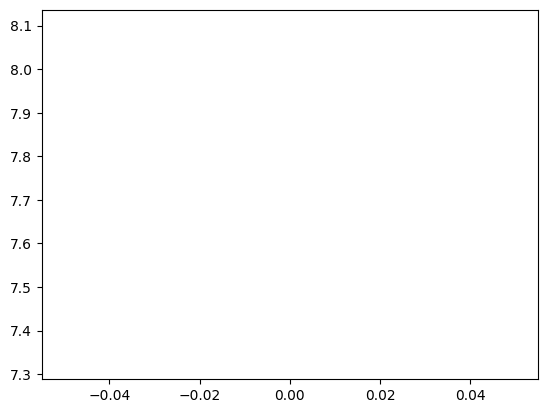

In [160]:
W = regression(Xt, y, k)